In [1]:
# PTB-XL Multi-Label CNN (Safe Thesis Version)

import pandas as pd
import numpy as np
import ast
import os
import wfdb
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# Load metadata
ptbxl_path = "/media/nicholas/Storage/Datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv"
scp_path = "/media/nicholas/Storage/Datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv"
waveform_path = "/media/nicholas/Storage/Datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

print("Loading metadata...")
df = pd.read_csv(ptbxl_path)
scp_df = pd.read_csv(scp_path)

Loading metadata...


In [3]:
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [4]:
# Parse SCP codes
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_keys'] = df['scp_codes'].apply(lambda x: list(x.keys()))

In [5]:
# Directly count all SCP codes without filtering by diagnostic
scp_counter = Counter()
df['scp_keys'].apply(scp_counter.update)

0        None
1        None
2        None
3        None
4        None
         ... 
21794    None
21795    None
21796    None
21797    None
21798    None
Name: scp_keys, Length: 21799, dtype: object

In [6]:
# Select top N most frequent SCP codes
N = 20
common_scps = [k for k, v in scp_counter.most_common(N)]
print(f"Using {len(common_scps)} SCP diagnostic classes: {common_scps}")

Using 20 SCP diagnostic classes: ['SR', 'NORM', 'ABQRS', 'IMI', 'ASMI', 'LVH', 'NDT', 'LAFB', 'AFIB', 'ISC_', 'PVC', 'IRBBB', 'STD_', 'VCLVH', 'STACH', '1AVB', 'IVCD', 'SARRH', 'NST_', 'ISCAL']


In [7]:
# Keep only records that have at least one of the top SCP codes
df['scp_common'] = df['scp_keys'].apply(lambda x: [k for k in x if k in common_scps])
df = df[df['scp_common'].map(len) > 0]
print(f"Samples after filtering for common SCP codes: {len(df)}")

Samples after filtering for common SCP codes: 21380


In [8]:
# Binarize multi-label targets
mlb = MultiLabelBinarizer(classes=common_scps)
y = mlb.fit_transform(df['scp_common'])

In [9]:
# Load raw ECG function
def load_ecg(record_path, signal_len=5000):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal.T  # (12, time)
    if signal.shape[1] < signal_len:
        pad_width = signal_len - signal.shape[1]
        signal = np.pad(signal, ((0, 0), (0, pad_width)), mode='constant')
    else:
        signal = signal[:, :signal_len]
    return signal

In [10]:
# Dataset class
class PTBXL_Dataset(Dataset):
    def __init__(self, df, y, base_dir, signal_len=5000):
        self.df = df
        self.y = y
        self.base_dir = base_dir
        self.signal_len = signal_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(path, self.signal_len)
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [12]:
# Build DataLoaders (Optimized)
train_dataset = PTBXL_Dataset(X_train, y_train, waveform_path)
test_dataset = PTBXL_Dataset(X_test, y_test, waveform_path)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,    # <-- use CPU cores
    pin_memory=True   # <-- helps with GPU data transfer
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=4,
    pin_memory=True
)

In [13]:
# CNN Model
class ECG_CNN(nn.Module):
    def __init__(self, num_classes):
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * 1250, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
# Initialize model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_CNN(num_classes=y.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
print(f"Using device: {device}")
print(f"Is CUDA available? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Current device index: {torch.cuda.current_device()}")

Using device: cuda
Is CUDA available? True
CUDA Device Name: NVIDIA GeForce RTX 3060 Ti
Current device index: 0


In [16]:
from tqdm import tqdm

epochs = 10  # <-- Make sure this exists

for epoch in range(epochs):
    model.train()
    total_loss = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for signals, labels in train_loader_tqdm:
        signals, labels = signals.to(device), labels.to(device)
        signals = signals.permute(0, 1, 2)

        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}, Avg Loss: {total_loss/len(train_loader):.4f}")



Epoch 1/10: 100%|█████████████████| 535/535 [00:10<00:00, 50.32it/s, loss=0.274]


Epoch 1, Avg Loss: 0.2345


Epoch 2/10: 100%|█████████████████| 535/535 [00:10<00:00, 50.95it/s, loss=0.199]


Epoch 2, Avg Loss: 0.1931


Epoch 3/10: 100%|█████████████████| 535/535 [00:10<00:00, 52.21it/s, loss=0.255]


Epoch 3, Avg Loss: 0.1675


Epoch 4/10: 100%|█████████████████| 535/535 [00:10<00:00, 50.94it/s, loss=0.142]


Epoch 4, Avg Loss: 0.1400


Epoch 5/10: 100%|█████████████████| 535/535 [00:10<00:00, 50.10it/s, loss=0.122]


Epoch 5, Avg Loss: 0.1099


Epoch 6/10: 100%|█████████████████| 535/535 [00:10<00:00, 51.60it/s, loss=0.099]


Epoch 6, Avg Loss: 0.0795


Epoch 7/10: 100%|████████████████| 535/535 [00:10<00:00, 50.93it/s, loss=0.0838]


Epoch 7, Avg Loss: 0.0535


Epoch 8/10: 100%|████████████████| 535/535 [00:10<00:00, 51.17it/s, loss=0.0463]


Epoch 8, Avg Loss: 0.0347


Epoch 9/10: 100%|█████████████████| 535/535 [00:10<00:00, 50.67it/s, loss=0.012]


Epoch 9, Avg Loss: 0.0223


Epoch 10/10: 100%|███████████████| 535/535 [00:10<00:00, 51.52it/s, loss=0.0166]

Epoch 10, Avg Loss: 0.0153


In [17]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        signals = signals.permute(0, 1, 2)
        outputs = model(signals)
        y_true.append(labels.cpu().numpy())
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

print("Classification Report:")
print(classification_report(y_true > 0.5, y_pred > 0.5, target_names=mlb.classes_))
print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred, average='macro'))


Classification Report:
              precision    recall  f1-score   support

          SR       0.83      0.83      0.83      3315
        NORM       0.81      0.82      0.82      1965
       ABQRS       0.52      0.32      0.40       623
         IMI       0.53      0.33      0.41       500
        ASMI       0.67      0.48      0.56       487
         LVH       0.59      0.54      0.57       432
         NDT       0.22      0.20      0.21       357
        LAFB       0.71      0.65      0.68       317
        AFIB       0.48      0.44      0.46       305
        ISC_       0.59      0.35      0.44       270
         PVC       0.37      0.38      0.37       243
       IRBBB       0.47      0.27      0.34       230
        STD_       0.26      0.16      0.19       192
       VCLVH       0.29      0.30      0.29       183
       STACH       0.52      0.30      0.38       152
        1AVB       0.12      0.07      0.09       170
        IVCD       0.14      0.08      0.10       155
    

/home/nicholas/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


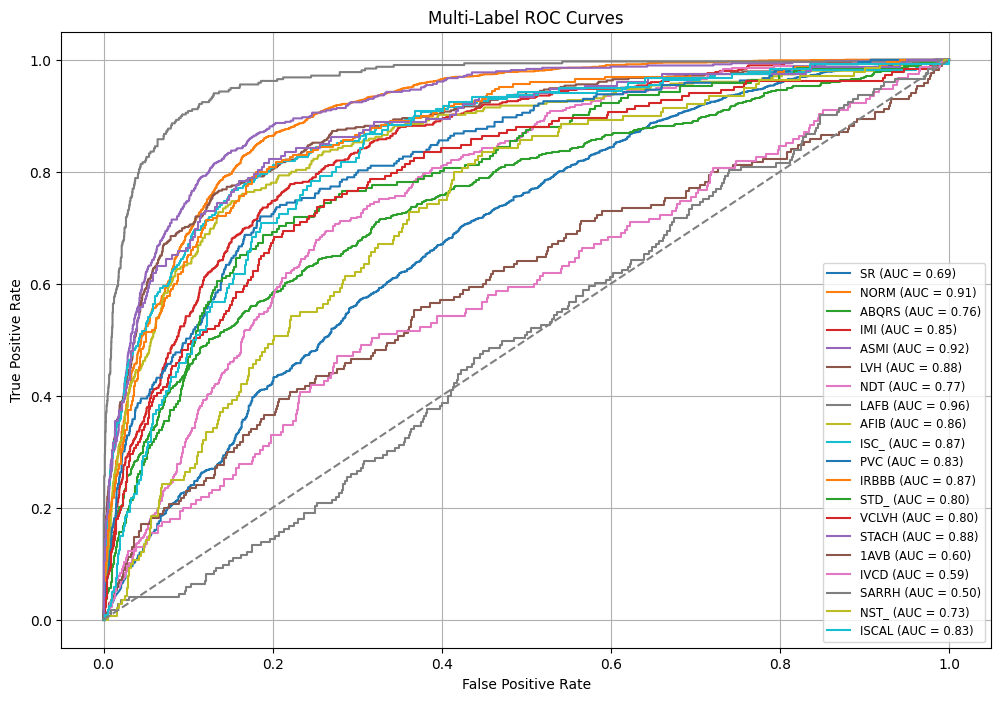

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))

for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Label ROC Curves')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.show()
